<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> SBP-SAT finite difference method for the 2D acoustic wave equation in velocity-pressure form </div>
        </div>
    </div>
</div>


---

This notebook is based on the paper [Dynamic earthquake rupture simulations on nonplanar faults embedded in 3D geometrically complex, heterogeneous Earth models](https://pangea.stanford.edu/~edunham/publications/Duru_Dunham_FD3d_JCP16.pdf)


##### Authors:
* Kenneth Duru

## Basic Equations ##

The source-free elastic wave equation in a heterogeneous 1D medium is 

\begin{align}
\rho(x)\frac{\partial v(x,t)}{\partial t} -\frac{\partial\sigma(x,t)}{\partial x} & = 0\\
\frac{1}{\mu(x)}\frac{\partial\sigma(x,t)}{\partial t} -\frac{\partial v(x,t)}{\partial x} & = 0  
\end{align}

with $\rho(x)$ the density, $\mu(x)$ the shear modulus and $x \in [0, L]$. At the boundaries $ x = 0, x = L$ we pose the general well-posed linear boundary conditions

\begin{equation}
\begin{split}
B_0(v, \sigma, Z_{s}, r_0): =\frac{Z_{s}}{2}\left({1-r_0}\right){v} -\frac{1+r_0}{2} {\sigma} = 0,  \quad \text{at} \quad x = 0, \\
 B_L(v, \sigma, Z_{s}, r_n): =\frac{Z_{s}}{2} \left({1-r_n}\right){v} + \frac{1+r_n}{2}{\sigma} = 0, \quad \text{at} \quad  x = L.
 \end{split}
\end{equation}

with the reflection coefficients $r_0$, $r_n$ being real numbers and  $|r_0|, |r_n| \le 1$. 

Note that at $x = 0$,  while  $r_0 = -1$ yields a clamped wall, $r_0 = 0$  yields  an absorbing boundary, and  with $r_0 = 1$  we have a free-surface boundary condition. Similarly, at $x = L$, $r_n = -1$ yields a clamped wall, $r_n = 0$ yields an absorbing boundary, and  $r_n = 1$  gives a free-surface boundary condition.

We introduce the mechanical energy defined by
\begin{equation}
E(t) = \int_0^L{\left(\frac{\rho(x)}{2} v^2(x, t) + \frac{1}{2\mu(x)}\sigma^2(x, t)\right) dx},
\end{equation}

where $E(t)$ is the sum of the kinetic energy and the strain energy.
We have 

\begin{equation}
\frac{d E(t)}{dt} = -v(0, t)\sigma(0, t) + v(L, t)\sigma(L, t) \le 0.
\end{equation}

From the boundary conditions, it is easy to check that  $v(0, t)\sigma(0, t) \ge 0$ and $v(L, t)\sigma(L, t) \le 0$, for all $|r_0|, |r_n| \le 1$. This energy loss through the boundaries is what the numerical method should emulate. 

1) Discretize the spatial domain $x$ into $N$ discrete nodes with the uniform spatial step $\Delta{x} = L/(N-1)$, denote the unknown fields at the nodes: $\mathbf{v}\left(t\right) = [v_1\left(t\right), v_2\left(t\right), \cdots, v_N\left(t\right)]$, and $\boldsymbol{\sigma}\left(t\right) = [\sigma_1\left(t\right), \sigma_2\left(t\right), \cdots, \sigma_N\left(t\right)]$.


2) At the grid-point $x_j = (j-1)\Delta{x}$: Approximate the spatial derivative by a finite difference operator $\partial v/\partial x\Big|_{x = x_j} \approx \left(\mathbf{D}\mathbf{v}\right)_j $. Here $\mathbf{D}$ is a finite difference matrix satisfying the summation-by-parts property:

\begin{align}
\mathbf{D} = \mathbf{H}^{-1}\mathbf{Q}, \quad \mathbf{Q} + \mathbf{Q} = \left(\boldsymbol{e}_{N}\boldsymbol{e}_{N}^T -\boldsymbol{e}_{1}\boldsymbol{e}_{1}^T\right), \quad \mathbf{H}^T = \mathbf{H} > 0,
\end{align}

where, $\boldsymbol{e}_{0} = [1, 0, \dots,  0 ]^T, \quad  \boldsymbol{e}_{L} = [ 0, 0, \dots,  1 ]^T$ and $\mathbf{H}$ defines a dicrete norm. We consider only diagonal norm SBP operators with $H_{jj} = h_j > 0$, and define the quadrature rule

\begin{equation}
 \sum_{i = 1}^{N} f(x_j)h_j \approx \int_{0}^{L}f(x) dx.
\end{equation}

The second order accurate SBP operator for first derivative is:
\begin{align}
\left(\mathbf{D}\mathbf{v}\right)_j = \frac{v_{j+1}-v_{j-1}}{2 \Delta{x}}, \quad j = 2, 3, \cdots N-1, \quad
\left(\mathbf{D}\mathbf{v}\right)_1 = \frac{v_{2}-v_{1}}{\Delta{x}},\quad
\left(\mathbf{D}\mathbf{v}\right)_N = \frac{v_{N}-v_{N-1}}{\Delta{x}}, \quad j = N.
\end{align}

Note that the interior stencils are centered, with second order accuracy and the boundary stencils are one-sided and first order accurate. 

Higher order SBP operators can be found in the book: High Order Difference Methods for Time Dependent PDE, by B. Gustafsson. In this notebook we implement SBP operators with interior accuracy 2, 4 and 6. The implementation of the spatial derivative operators can be found in the file first_derivative_sbp_operators.py

To construct a stable  semi-discrete approximation we replace the spatial derivatives by the SBP operators, and add the boundary conditions as SAT-terms with special penalty weights having:

\begin{align}
\frac{d \mathbf{v}(t)}{d t} = {\boldsymbol{\rho}}^{-1}
\left(\mathbf{D} \boldsymbol{\sigma}(t) - \underbrace{\mathbf{H}^{-1}\left(\tau_{11}\boldsymbol{e}_{1}B_0\left(v_1, \sigma_1, Z_{s}, r_0\right) + \tau_{12}\boldsymbol{e}_{N}B_L\left(v_N, \sigma_N, Z_{s}, r_n\right)\right)}_{SAT \to 0}\right),
\end{align}

\begin{align}
\frac{d \boldsymbol{\sigma}(t)}{d t} = \boldsymbol{\mu}
\left(\mathbf{D} \mathbf{v}(t) + \underbrace{\mathbf{H}^{-1}\left(\tau_{21}\frac{\boldsymbol{e}_{1}}{Z_{s}}B_0\left(v_1, \sigma_1, Z_{s}, r_0\right) - \tau_{22}\frac{\boldsymbol{e}_{N}}{Z_{s}}B_L\left(v_N, \sigma_N, Z_{s}, r_n\right)\right)}_{SAT \to 0}\right).
\end{align}
Here $\tau_{ij}$ are penalty parameters determined by requiring stability.

Approximate the mechanical energy by the above quadrature rule, having 
\begin{align}
\mathcal{E}( t) = \sum_{j}^{N}\frac{1}{2}\left(\rho_jv_j^2 + \frac{1}{\mu_j}\sigma_j^2\right)h_j > 0.
\end{align}

By chosing the penalty parameters $\tau_{ij} = 1$, the semi-discrete approximation satisfies the energy estimate:
\begin{align}
\frac{d \mathcal{E}( t)}{d t} = -\frac{1}{2}\left(\left(1-r_0\right)Zv_1^2 + \frac{\left(1+r_0\right)}{Z}v_1^2 +
\left(1-r_n\right)Zv_N^2 + \frac{\left(1+r_n\right)}{Z}v_N^2\right) \le 0.
\end{align}


3) The discrete mechanical energy can never grow in time, and thus the semidiscrete numerical approximation is asymptotically stable.

4)  Time integration can be performed using any stable time stepping scheme. This notebook implements the fourth order accurate Runge-Kutta method. 

To keep the problem simple, we use as spatial initial condition a Gauss function with half-width $\delta$

\begin{equation}
v(x,t=0)  = e^{-1/\delta^2 (x - x_{o})^2}, \quad \sigma(x,t=0) = 0
\end{equation}

**** Exercises****



In [1]:
# Parameters initialization and plotting the simulation
# Import necessary routines
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
import RK4_2D

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook

<IPython.core.display.Javascript object>


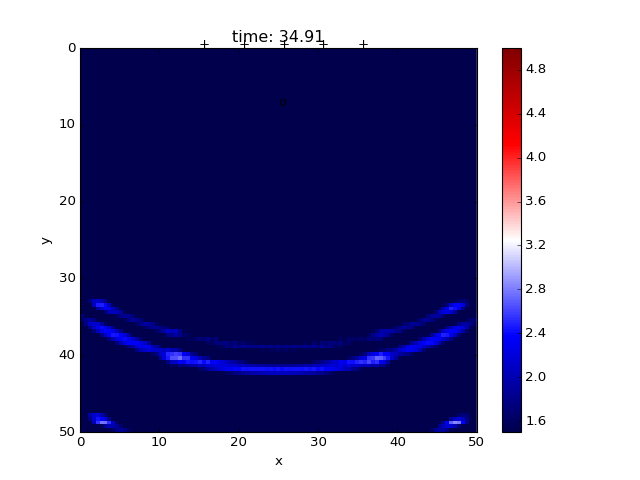

<IPython.core.display.Javascript object>


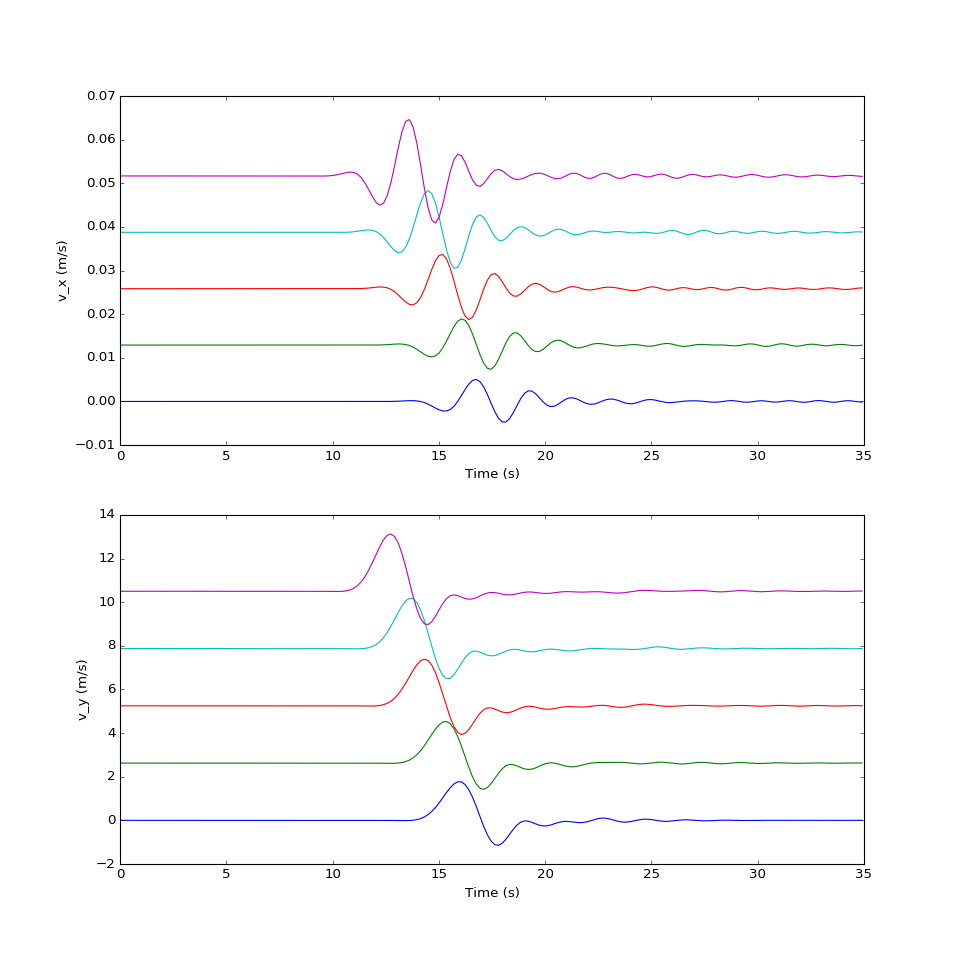

In [2]:

Lx = 50.0     # length of the domain (x-axis)
Ly = 50.0     # width of the domain (y-axis)

nx = 101       # grid points in x
ny = 101       # grid points in y
nt = 201      # number of time steps

dx = Lx/nx    # spatial step in x
dy = Ly/ny    # spatial step in y

ist = 100     # shifting of source time function
isnap = 1     # snapshot frequency
nf = 3        # number of fields

cp = 1.418    # compresional wave speed [m/s]
rho = 1.0     # density [g/cm^3]

# source parameters
x0 = 25.0        # [km]
y0 = 7.5         # [km]
t0 = 0.7         # [s]
T =  0.1149      # [s]
M0 = 1000        # [MPa]

source_type = 'Gaussian'

source_parameter = [x0, y0, t0, T, M0, source_type]

# extract bulk modulus
lam = rho*cp**2

dt = 0.5/cp*dx    # Time step

order = 4        # spatial order of accuracy

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"

model_type = "homogeneous"

# Initialize velocity model
Mat = np.zeros((nx, ny, 2))

if model_type == "homogeneous":
    Mat[:,:,0] += rho
    Mat[:,:,1] += lam

elif model_type == "random":
    pert = 0.25
    r_rho = 2.0 * (np.random.rand(nx, ny) - 0.5) * pert
    r_lambda = 2.0 * (np.random.rand(nx, ny) - 0.5) * pert
    
    Mat[:,:,0] += rho*(1.0 + r_rho)
    Mat[:,:,1] += lam*(1.0 + r_lambda)
    
    
# Initialize pressure at different time steps and the second
# derivatives in each direction
F = np.zeros((nx, ny, nf))
Fnew = np.zeros((nx, ny, nf))

X = np.zeros((nx, ny))
Y = np.zeros((nx, ny))
              
p = np.zeros((nx, ny))


for i in range(0, nx):
    for j in range(0, ny):
        X[i, j] = i*dx
        Y[i,j] = j*dy

v = 5.0
p = np.sqrt(F[:,:,0]**2)

image = plt.imshow(p.transpose(), aspect='auto',extent=[0,Lx,Ly,0]
          ,cmap = 'seismic', vmin=1.5, vmax=+v, animated=True, 
          interpolation='none')

# Receiver locations
rx = np.array([15, 20, 25, 30, 35])
ry = np.array([0, 0, 0, 0, 0])

irx = np.array([15, 20, 25, 30, 35])
iry = np.array([0, 0, 0, 0, 0])

for i in range(len(rx)):
    irx[i] = (np.ceil(rx[i]*dx))
    iry[i] = (np.ceil(ry[i]*dy))
    
    

seisvx = np.zeros((len(irx), nt))
seisvy = np.zeros((len(irx), nt))


# Plot the receivers
for x, z in zip(rx, ry):
    plt.text(x, z, '+')

plt.text(x0, y0, 'o')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.show()


# Boundary reflection coefficients
r = np.array([0.,0.,1.,0.])


# required for seismograms
ir = np.arange(len(irx))

#################################################

# Time-stepping 
for it in range(nt):
    
    t = it*dt
    
    #4th order Runge-Kutta 
    RK4_2D.acoustics_RK4_2D(Fnew, F, Mat, X, Y, t, nf, nx, ny, dx, dy, dt, order, r, source_parameter)

    # update fields
    F = Fnew
    
    #extract absolute pressure fields for visualization
    p = np.sqrt(F[:,:,0]**2)

    # update time
    t = it*dt
    
    # Plot every isnap-th iteration
    if it % isnap == 0:                    # you can change the speed of the plot by increasing the plotting interval
        plt.title("time: %.2f" % t)
        image.set_data(p.transpose())
        plt.gcf().canvas.draw()
        #plt.show()
        #print(it)
    
    # Save seismograms
    seisvx[ir, it] = F[(irx[ir]), (iry[ir]), 1]
    seisvy[ir, it] = F[(irx[ir]), (iry[ir]), 2]
    
plt.ioff()
plt.figure(figsize=(12, 12))

plt.subplot(211)
ymax = seisvx.ravel().max()
time = np.arange(nt) * dt
for ir in range(len(seisvx)):
    plt.plot(time, seisvx[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('v_x (m/s)')

plt.subplot(212)
ymax = seisvy.ravel().max()
for ir in range(len(seisvy)):
    plt.plot(time, seisvy[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('v_y (m/s)')

plt.show()


